# Анализ убытков приложения ProcrastinatePRO+

**Цель исследования:** нужно разобраться в причинах убытков приложения Procrastinate Pro+ за последние несколько месяцев. На рекламные каналы для привлечения пользователей была вложена куча денег, а толку никакого.

**Ход исследования**: данные получим из файлов visits_info_short.csv, orders_info_short.csv, costs_info_short.csv. О качестве данных ничего не известно.

Исследование пройдёт в семь этапов:

1. Загрузка и обзор данных.
2. Предобработка данных.
3. Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии
4. Исследовательский анализ данных.
5. Маркетинг:  
   -Общая сумма затрат;    
   -Затраты на каждый источник;      
   -Динамика затрат по времени;    
   -Средняя стоимость привлечения одного покупателя из каждого источника.  
6. Оценка окупаемости рекламы для привлечения пользователей  
   -Анализ общей окупаемости рекламы;  
   -Анализ окупаемости рекламы с разбивкой по устройствам;  
   -Анализ окупаемости рекламы с разбивкой по странам;  
   -Анализ окупаемости рекламы с разбивкой по рекламным каналам;  
   -Анализ обнаруженных проблем
7. Общий вывод

## Загрузка и обзор данных 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


## Предобработка данных

In [9]:
#наименование столбцов приводим в нижний и змеиный регистр 
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()
visits = visits.rename(columns={'user id': 'user_id',
                       'session start': 'session_start',
                       'session end': 'session_end'})
orders = orders.rename(columns={'user id': 'user_id',
                       'event dt': 'event_dt'})

In [10]:
#переводим в датетайм
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [11]:
#проверяем на наличие дубликатов
print('Количество дубликтов visits:', visits.duplicated().sum())
print('Количество дубликтов orders:', orders.duplicated().sum())
print('Количество дубликтов costs:', costs.duplicated().sum())

Количество дубликтов visits: 0
Количество дубликтов orders: 0
Количество дубликтов costs: 0


In [12]:
#удаляем дубликаты
orders = orders.drop_duplicates()
print('Количество дубликтов orders:', orders.duplicated().sum())

Количество дубликтов orders: 0


Проверяем на наличие пропусков

In [13]:
pd.DataFrame(round(visits.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
region,0.000000
device,0.000000
channel,0.000000
session_start,0.000000
session_end,0.000000


In [14]:
pd.DataFrame(round(orders.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
revenue,0.000000


In [15]:
pd.DataFrame(round(costs.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
dt,0.000000
channel,0.000000
costs,0.000000


Наменование столбцов переведены в нижний и змеиный регистр  
Столбцы с временем переведены в формат datetime  
Обнаруженные дубликаты удалены с таблицы orders  
Пропусков в данных не обнаружено

## Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии

In [16]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles



In [17]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [18]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi()

In [20]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [22]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

In [24]:
#получаем профили пользователей, воспользуемся функцией get_profiles
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [25]:
#момент анализа
observation_date = datetime(2019, 11, 1).date()  
#горизонт анализа
horizon_days = 14  

In [26]:
#минимальная дата привлечения пользователей
min_analysis_date = profiles['dt'].min()
min_analysis_date 

datetime.date(2019, 5, 1)

In [27]:
#максимальная дата привлечения пользователей
max_analysis_date= profiles['dt'].max()
max_analysis_date

datetime.date(2019, 10, 27)

У нас есть минимальная и максимальная даты и они совпадают с заданием.


**Посмотрим из каких стран больше всего приходят посетители и выясним какая страна дает больше платящих посетителей**

In [28]:
#посмотрим какие страны у нас имеются
visits['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

In [29]:
#количество посетителей
country = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
country.columns = country.columns.droplevel(0)
country = country.rename(columns={'nunique': 'users',
                       'sum': 'payer_users',
                       'mean': 'share'})
country['prc'] = country['users']/country['users'].sum()*100
country.sort_values(by='users',ascending=False)

,users,payer_users,share,prc
region,,,,
United States,100002,6902,0.069019,66.664445
UK,17575,700,0.039829,11.716042
France,17450,663,0.037994,11.632713
Germany,14981,616,0.041119,9.986801


Около 70% посетителей из Америки. У Англии и Франции разница неощутимая. Меньше всего посетителей из Германии. 
По платящим пользователям Америка также лидирует. Больше посетителей - больше денег.

**Посмотрим на устройства посетителей**

In [30]:
#посмотрим какие устройства у нас имеются
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [31]:
device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
device.columns = device.columns.droplevel(0)
device = device.rename(columns={'nunique': 'users',
                       'sum': 'payer_users',
                       'mean': 'share'})
device['prc'] = device['users']/device['users'].sum()*100
device.sort_values(by='users',ascending=False)

,users,payer_users,share,prc
device,,,,
iPhone,54479,3382,0.062079,36.317396
Android,35032,2050,0.058518,23.353421
PC,30455,1537,0.050468,20.302251
Mac,30042,1912,0.063644,20.026932


Около 40% заходят с iPhone, за ним Andriod. У PC и Mac разница неощутимая. По платящим посетителям лидирует iPhone.

**Посмотрим на рекламные каналы**

In [32]:
#посмотрим какие каналы у нас имеются
costs['channel'].value_counts()

MediaTornado          180
LeapBob               180
lambdaMediaAds        180
YRabbit               180
WahooNetBanner        180
RocketSuperAds        180
FaceBoom              180
OppleCreativeMedia    180
TipTop                180
AdNonSense            180
Name: channel, dtype: int64

In [33]:
channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
channel.columns = channel.columns.droplevel(0)
channel = channel.rename(columns={'nunique': 'users',
                       'sum': 'payer_users',
                       'mean': 'share'})
channel['prc'] = channel['users']/channel['users'].sum()*100
channel.sort_values(by='share',ascending=False)

,users,payer_users,share,prc
channel,,,,
FaceBoom,29144,3557,0.122049,19.428297
AdNonSense,3880,440,0.113402,2.586529
lambdaMediaAds,2149,225,0.104700,1.432590
TipTop,19561,1878,0.096007,13.039971
RocketSuperAds,4448,352,0.079137,2.965175
WahooNetBanner,8553,453,0.052964,5.701696
YRabbit,4312,165,0.038265,2.874513
MediaTornado,4364,156,0.035747,2.909178
LeapBob,8553,262,0.030633,5.701696


Больше всего посетителей приходят сами по себе (organic). Больше всего платящих посетителей приходят через канал FaceBoom. За ним TipTop и Organic. Потом проявляется резкий провал.  

## Маркетинг


### Общая сумма затрат

In [34]:
#посмотрим на таблицу затрат
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [35]:
print('Всего затрат на рекламу:', round(costs['costs'].sum()))

Всего затрат на рекламу: 105497


### Затраты на каждый источник

In [36]:
#общая сумма затрат по каждому источнику
cost = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
cost['prc'] = cost['costs']/cost['costs'].sum()*100
cost

,costs,prc
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


На популярные каналы тратится больше. Видим, что два канала съели более 80% бюджета.

### Динамика затрат по времени

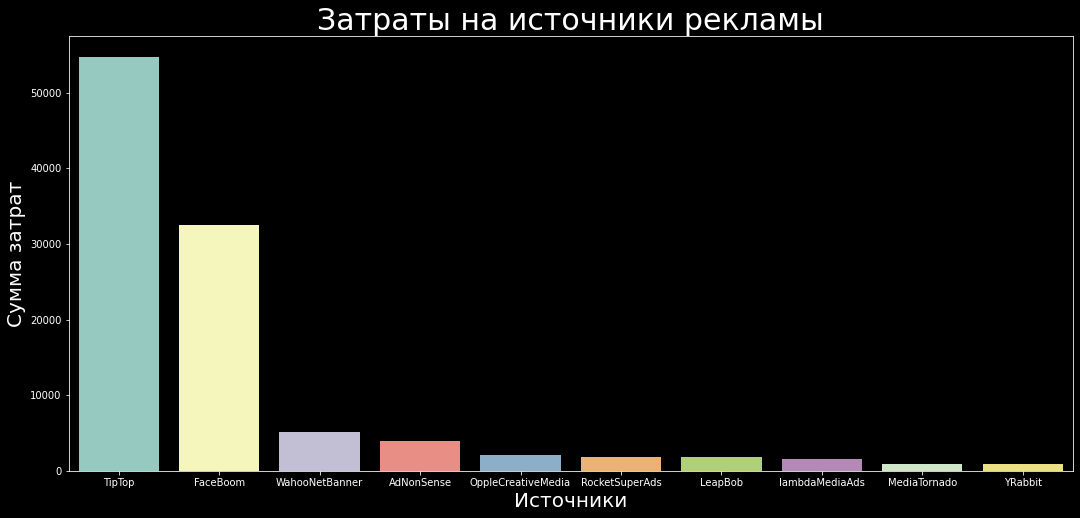

In [37]:
#визуализация затрат по источникам
plt.figure(figsize=(18,8))
sns.barplot(x=cost.index, y='costs', data=cost)
plt.title('Затраты на источники рекламы', fontsize=30)
plt.xlabel('Источники', fontsize=20)
plt.ylabel('Сумма затрат', fontsize=20)
plt.show()

Больше всего затрат у канала TipTop, более 50% от суммы приходит на него. 

In [38]:
#для визуализации изменения метрик во времени выделяем месяц 
costs['dt_month'] = pd.to_datetime(costs['dt']).dt.month

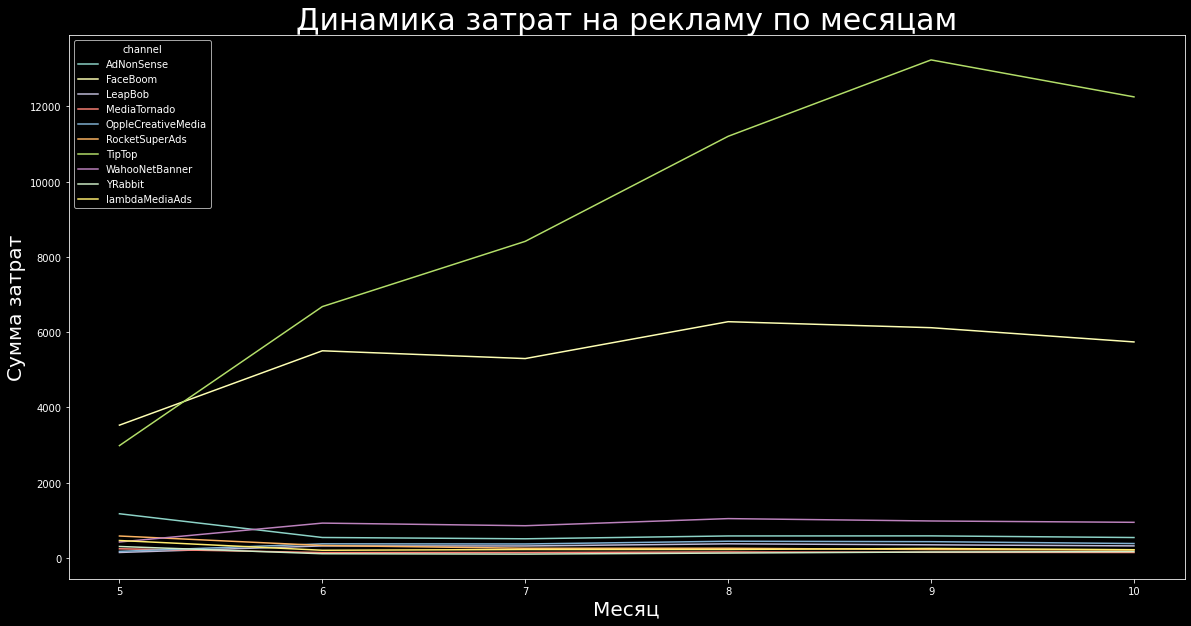

In [39]:
#визуализация по месяцам на каждый источник рекламы
costs.pivot_table(index = 'dt_month', columns = 'channel', values = 'costs' , aggfunc='sum').plot(figsize = (20,10))
plt.title('Динамика затрат на рекламу по месяцам', fontsize=30)
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Сумма затрат', fontsize=20)
plt.show()

Наблюдается повышение затрат с течением времени на TipTop (с 3000 до 13000) и FaceBoom. По остальным каналам все стабильно.

### Средняя стоимость привлечения одного покупателя из каждого источника

In [40]:
# находим LTV с разбивкой по каналам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
#средняя стоимость посетителей по каналам привлечения
round(roi_grouped['cac'], 2).sort_values(ascending=False).reset_index()

,channel,cac
0,TipTop,2.76
1,FaceBoom,1.11
2,AdNonSense,1.01
3,lambdaMediaAds,0.73
4,WahooNetBanner,0.60
5,RocketSuperAds,0.42
6,OppleCreativeMedia,0.25
7,MediaTornado,0.22
8,YRabbit,0.22
9,LeapBob,0.21


Обходятся популярные каналы дороже



In [41]:
# исключение органических пользователей из таблицы
profiles = profiles.query('channel != "organic"')

In [42]:
#средняя стоимость одного посетителя по всему проекту без канала 'organic'
round(profiles['acquisition_cost'].mean(), 2)

1.13

Общая сумма на затраты по рекламе составило 105497, наибольшие расходы у канала TipTop - 54751,3 и FaceBoom - 32445.60	
Средняя стоимость посетителей у канала TipTop в разы больше чем остальные и составляет 2,76. За ним идут каналы FaceBoom 1.11 и AdNonSense 1.01.  
График показал что траты на рекламу у канала TipTop возрастали с каждым месяцем  
Средняя стоимость привлечения посетителя составило 1.13

## Оценка окупаемости рекламы для привлечения пользователей

### Анализ общей окупаемости рекламы

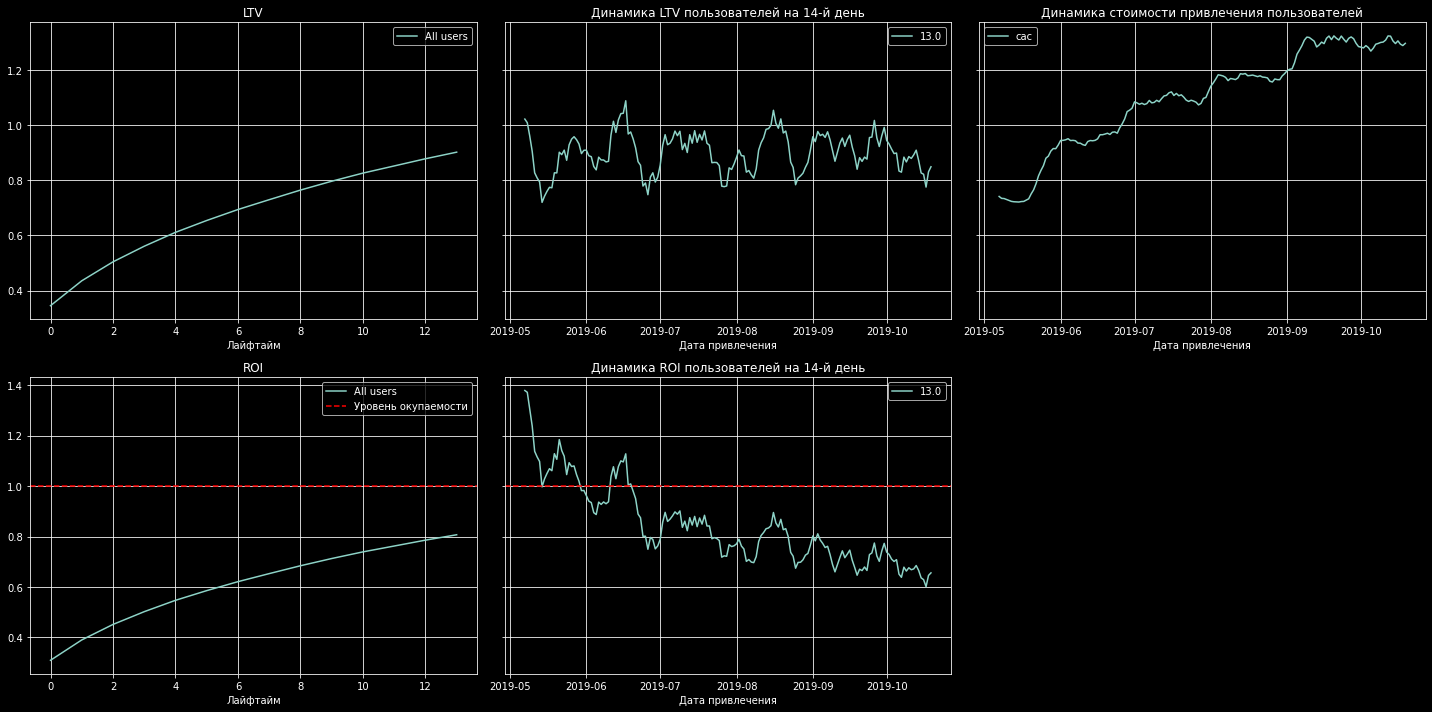

In [43]:
#считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Стоимость привлечения посетителя повышается: от 0.7 до 1.3  
Судя по графикам "ROI" и "динамика ROI" можно сказать что реклама в целом не окупается. За 14 дней ROI в районе 80%  
На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен  
Наблюдаются явные проблемы
 

### Анализ окупаемости рекламы с разбивкой по устройствам

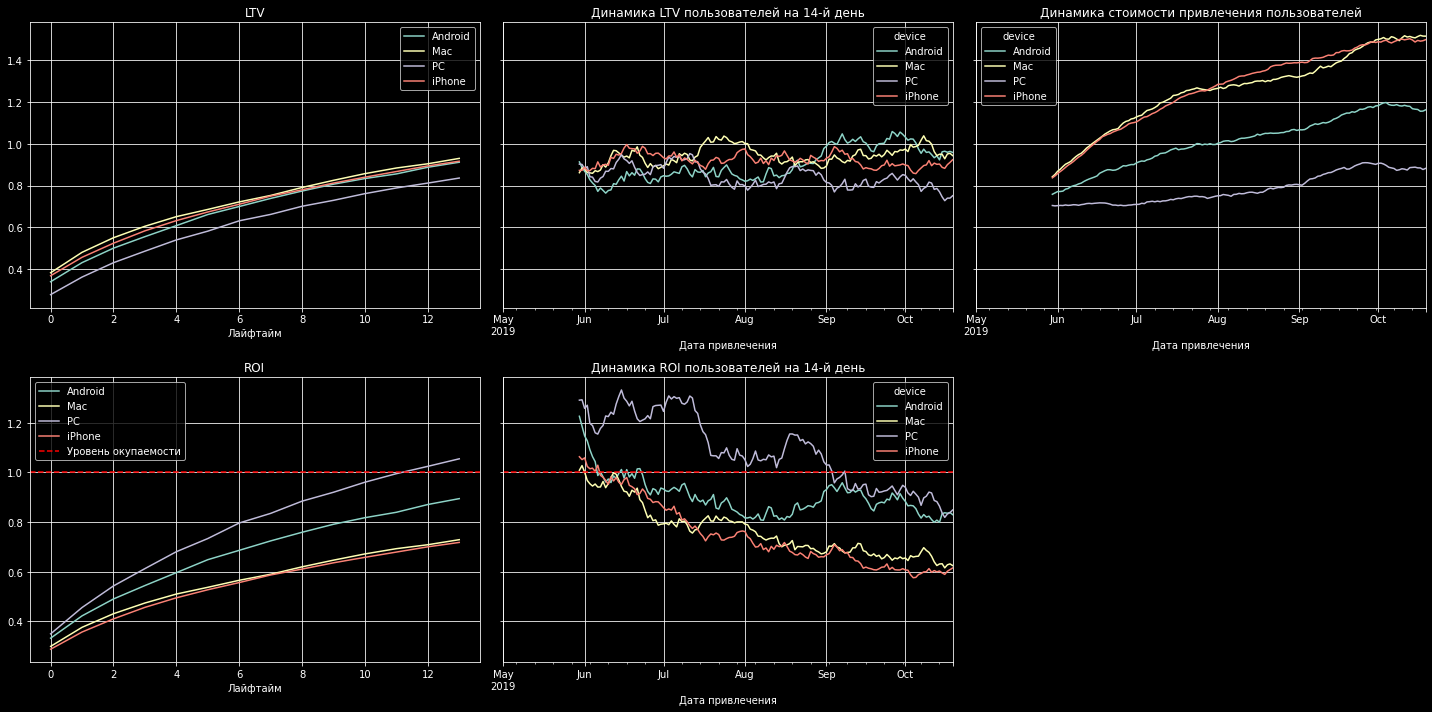

In [44]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

Стоимость привлечения посетителей растет, больше всех у iPhone и Mac   
Окупаются лишь посетители с PC. Но в динамике видим, что и он с сентября перестает окупаться при наименьших расходах по стоимости привлечения 

### Анализи окупаемости рекламы с разбивкой по странам

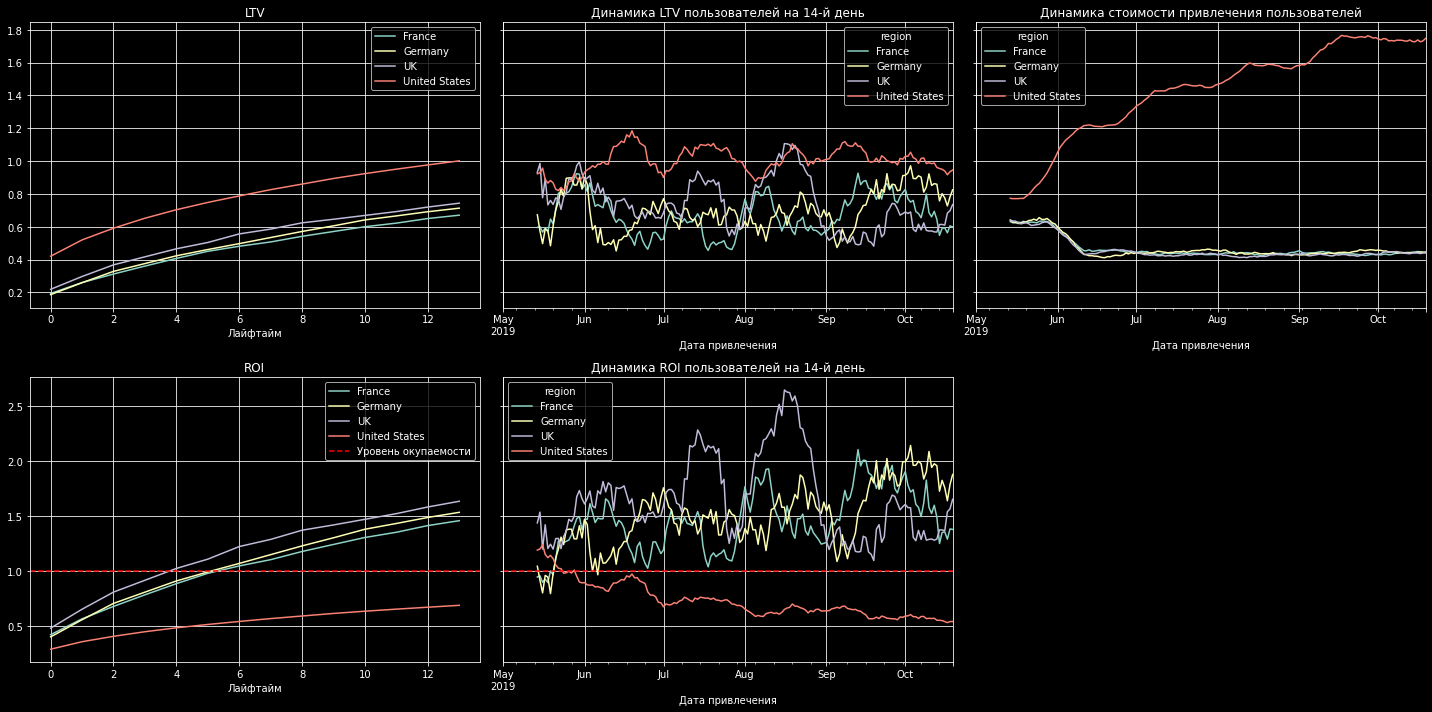

In [45]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Стоимость привлечения посетителей из Америки выросла. Примерно с 0.8 до 1.8    
Только посетители из Америки не окупаются  
Надо посмотреть только рынок Америки

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

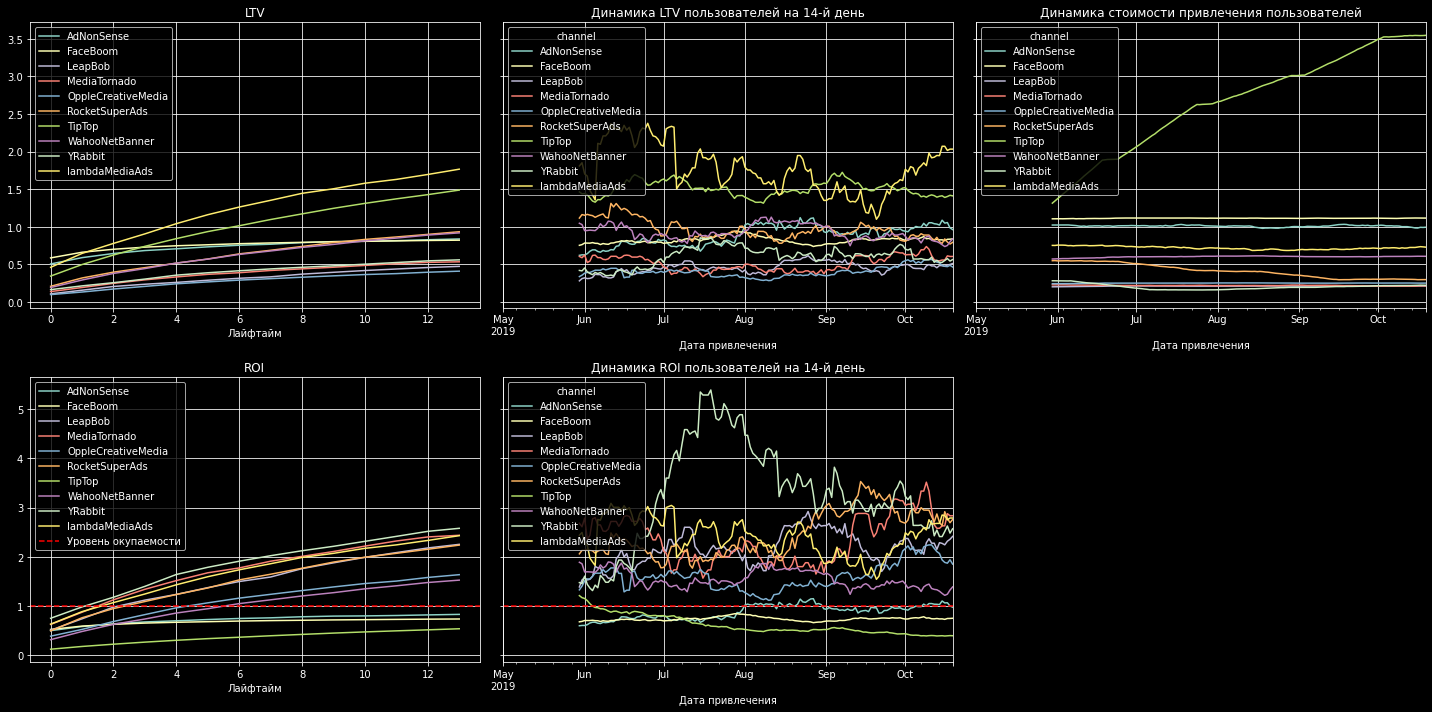

In [46]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

Стоимость привлечения пользователей с канала TipTop выросла более чем в 2 раза  
Определились проблемные каналы: это каналы TipTop, FaceBoom, AdNonSense, которые не окупаются

### Анализ обнаруженных проблем

**Посетители из Америки**

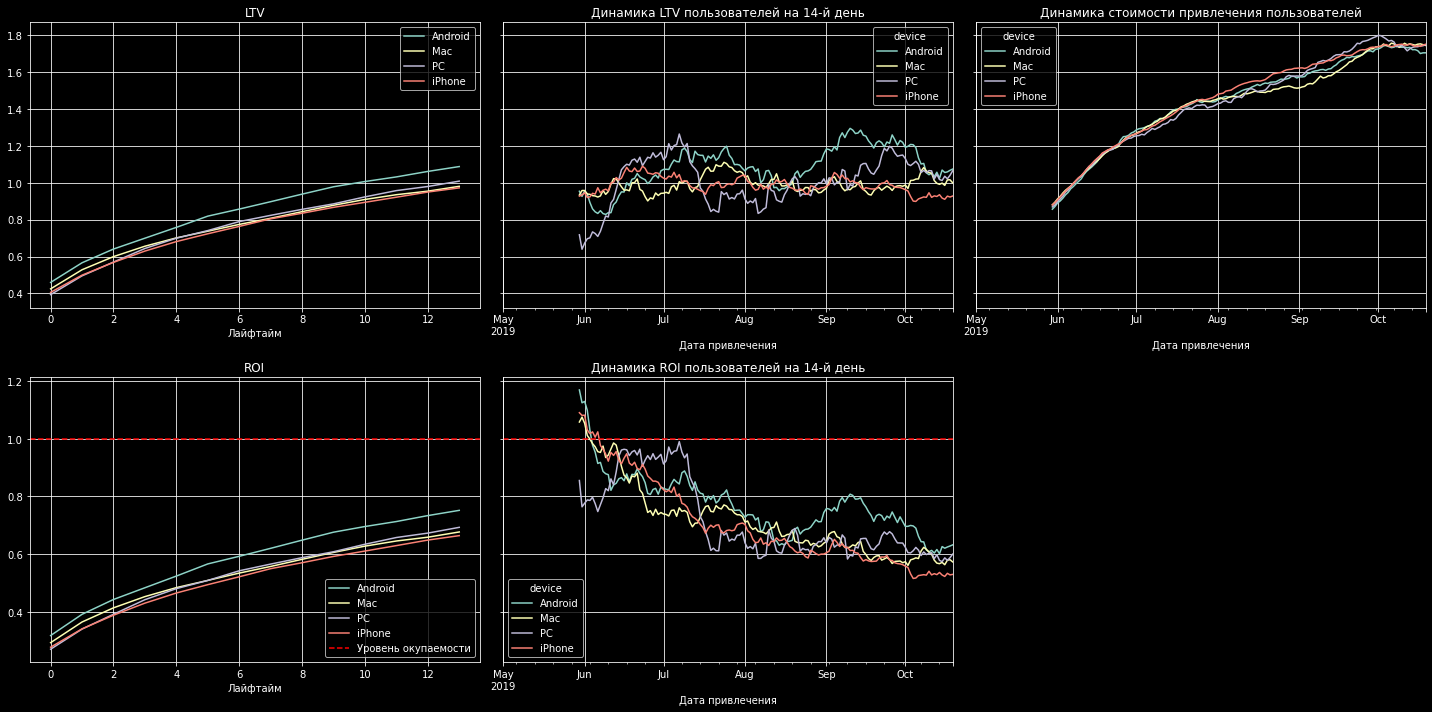

In [47]:
#смотрим окупаемость с разбивкой по устройствам
profiles_usa = profiles.query('region == "United States"')
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

Ни одно устройство не окупается, стоимость привлечения посетителей практически одинаковая поднимается во всех устройствах

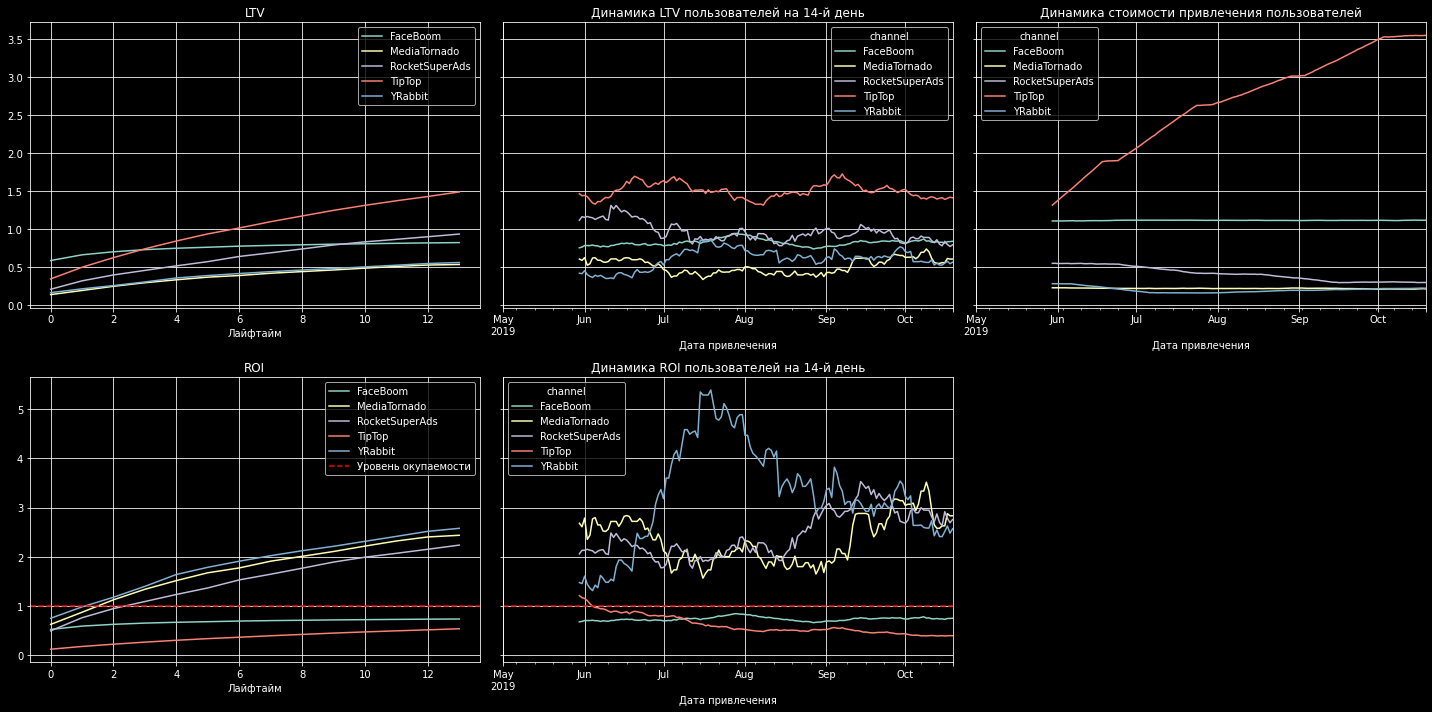

In [48]:
#смотрим окупаемость с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

В Америке у канала TipTop стоимость привлечения в разы больше чем остальные каналы, с этого канала посетители не приходят. Также затраты на рекламу на этом канале не окупились.

**Посмотрим на конверсии и удержании с разбивкой по странам, устройствам и каналам**

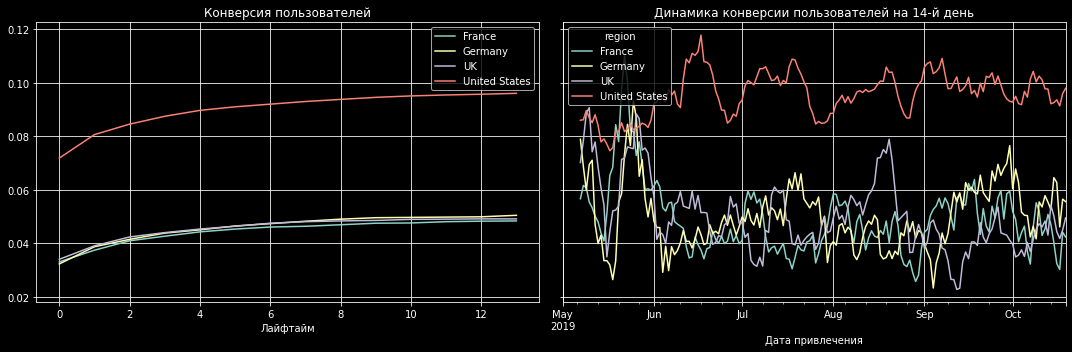

In [49]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Посетители из Америки конвертируются хорошо, причем постоянно

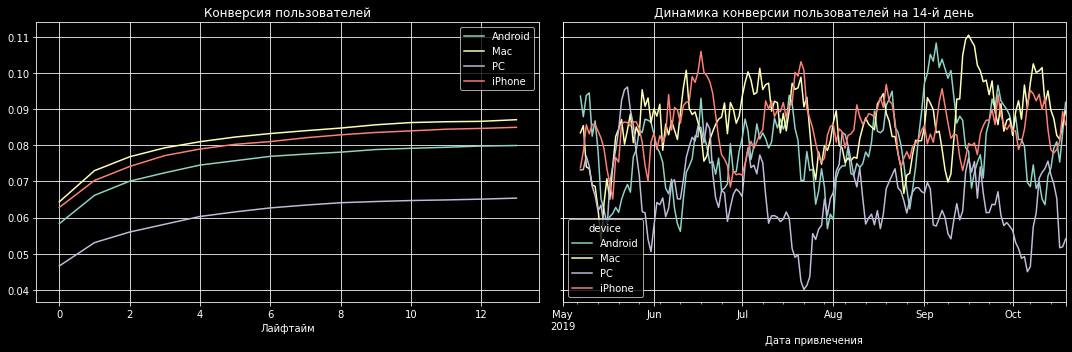

In [50]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

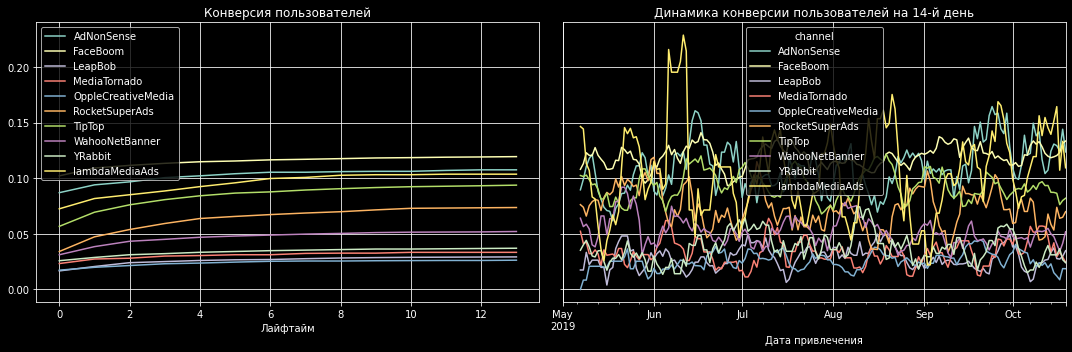

In [51]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

С конверсией вроде бы все хорошо, посмотрим на удержание

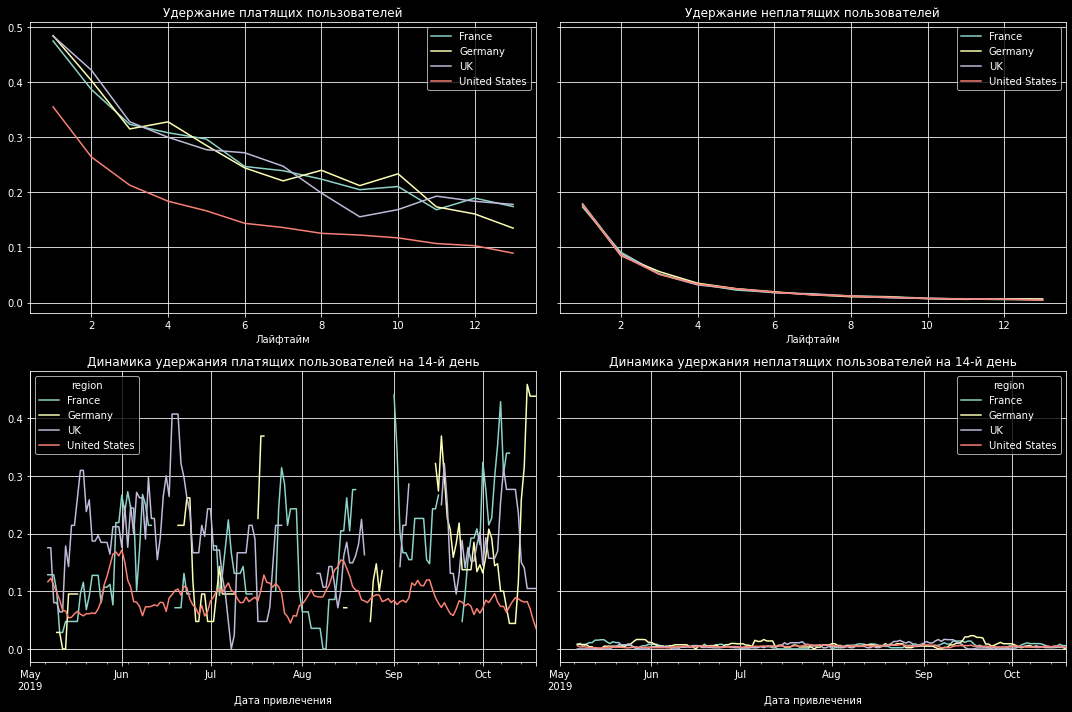

In [52]:
# смотрим удержание с разбивкой по странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Еще одна проблема в Америке: посетители плохо удерживаются, почти в 2 раза меньше чем остальные страны

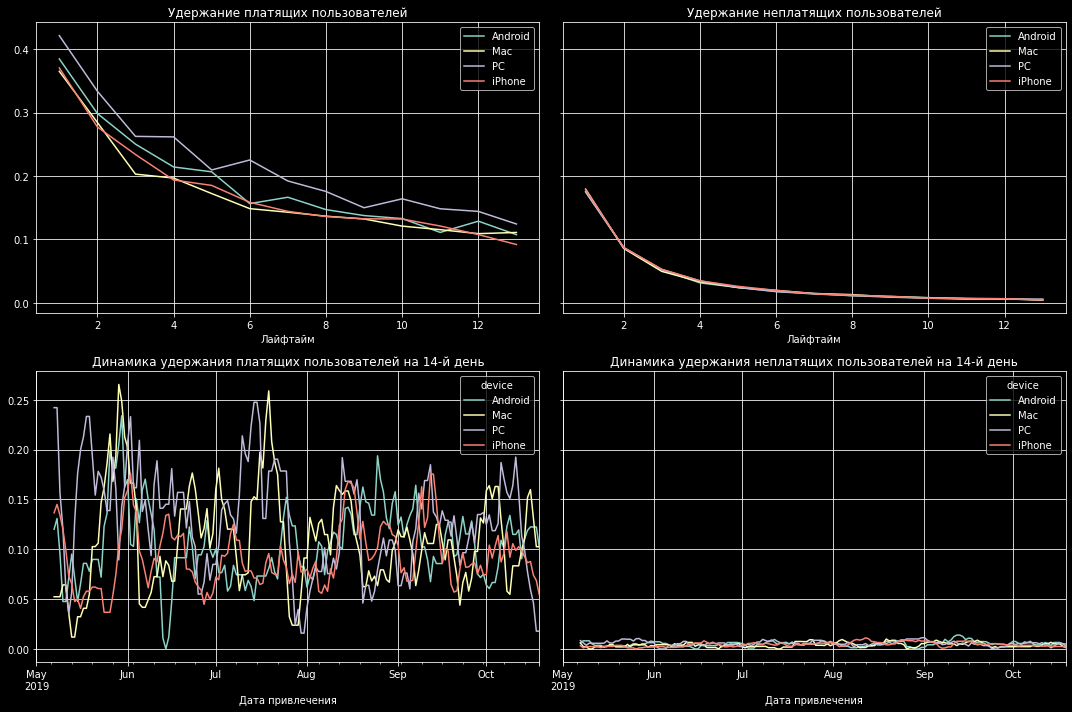

In [53]:
# смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Здесь существенных отклонений не имеется. Все идут вровень.

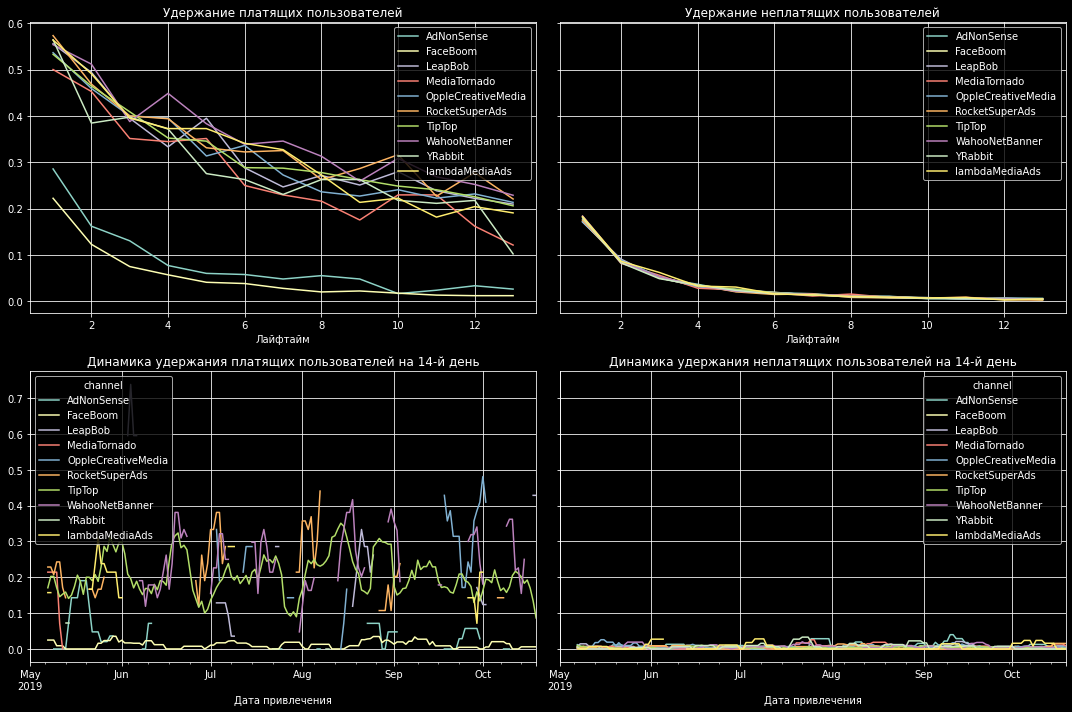

In [54]:
# смотрим удержание с разбивкой по каналам
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим причину не окупаемости каналов FaceBoom и AdNonSense. Удержание посетителей каналов FaceBoom и AdNonSense ниже чем остальные каналы, примерно на 20%

**Исключим из списка посетителей из Америки и посмотрим на окупаемость рекламы по Европе**

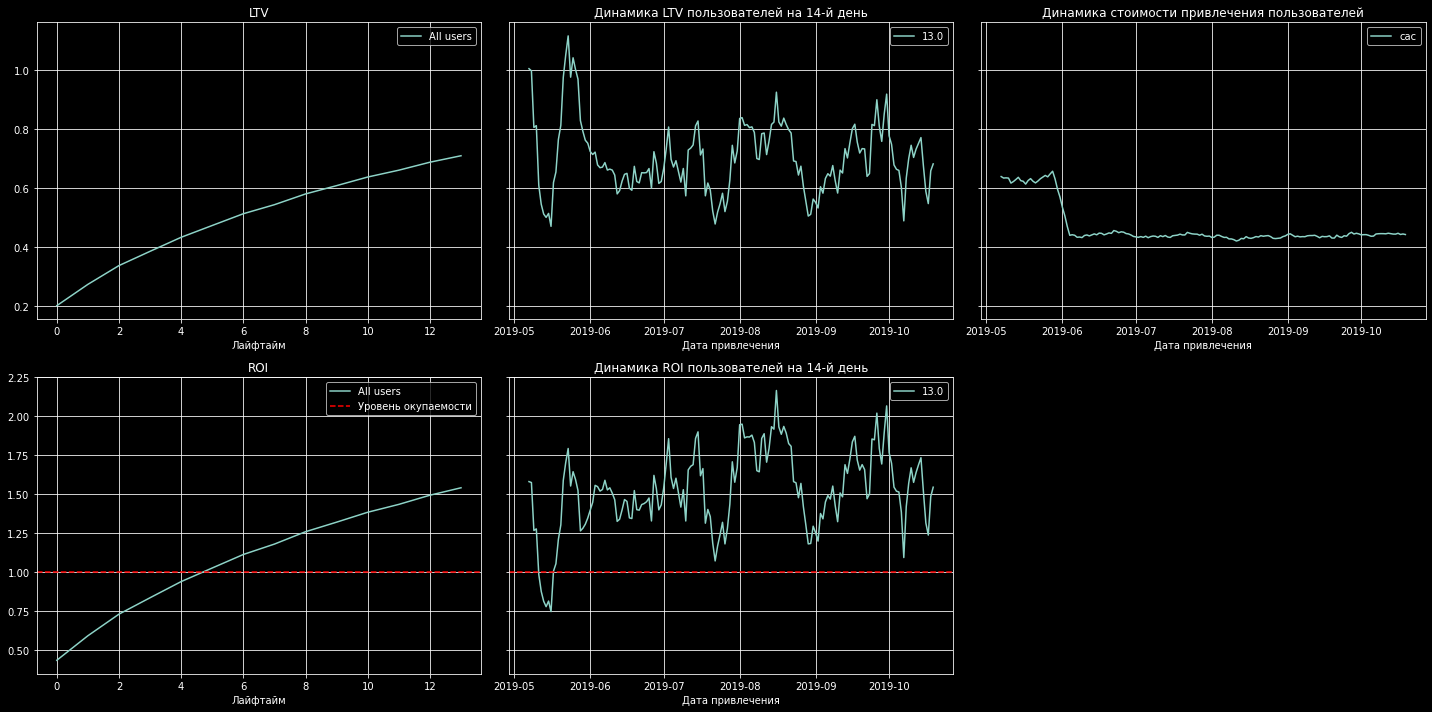

In [55]:
profiles_other = profiles.query('region != "United States"')
#считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_other, orders, observation_date, horizon_days
)
#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По остальным странам реклама окупается, все хорошо. Проблема неокупаемости рекламы у нас только в Америке.

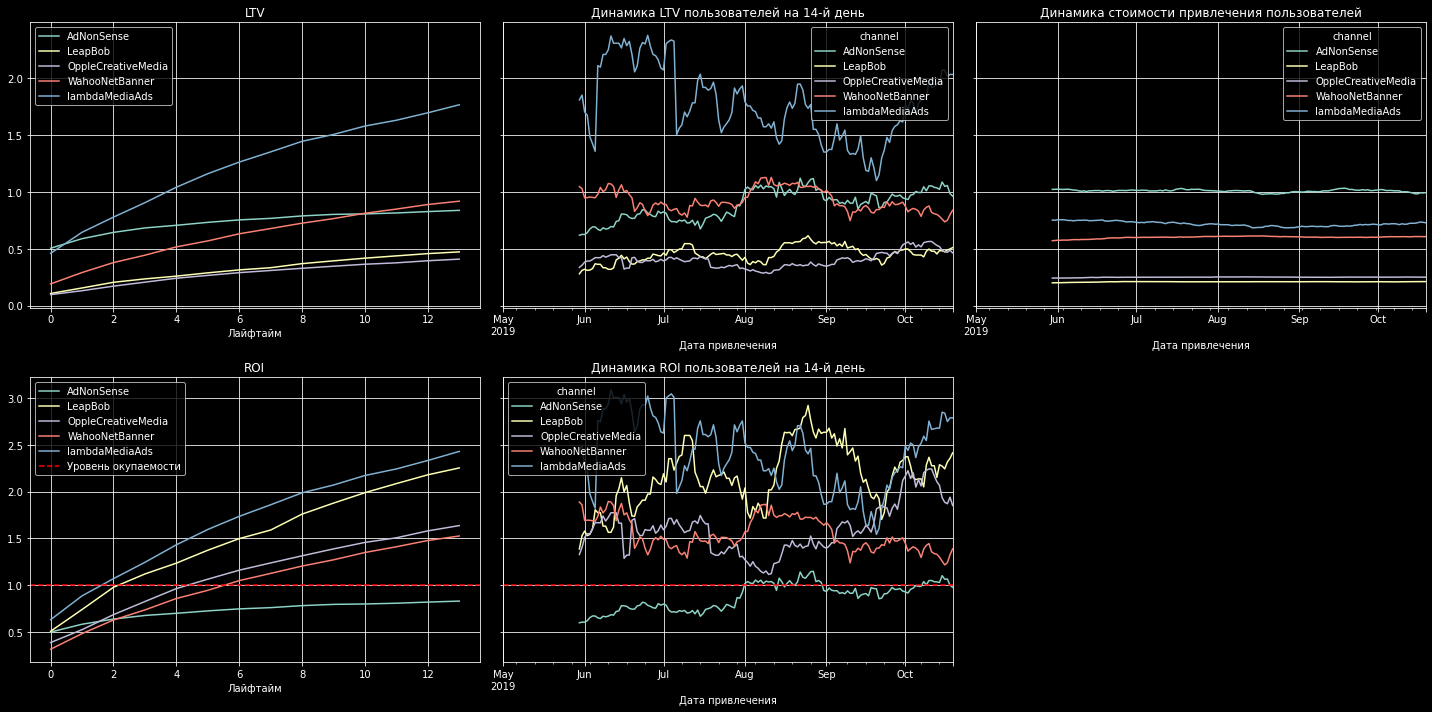

In [56]:
#смотрим окупаемость с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_other, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

Самые затратные каналы TipTop и FaceBoom работают только в Америке. САС стабилен, один рекламный канал только не окупается AdNonSense 3911.25 (4 место по расходам)

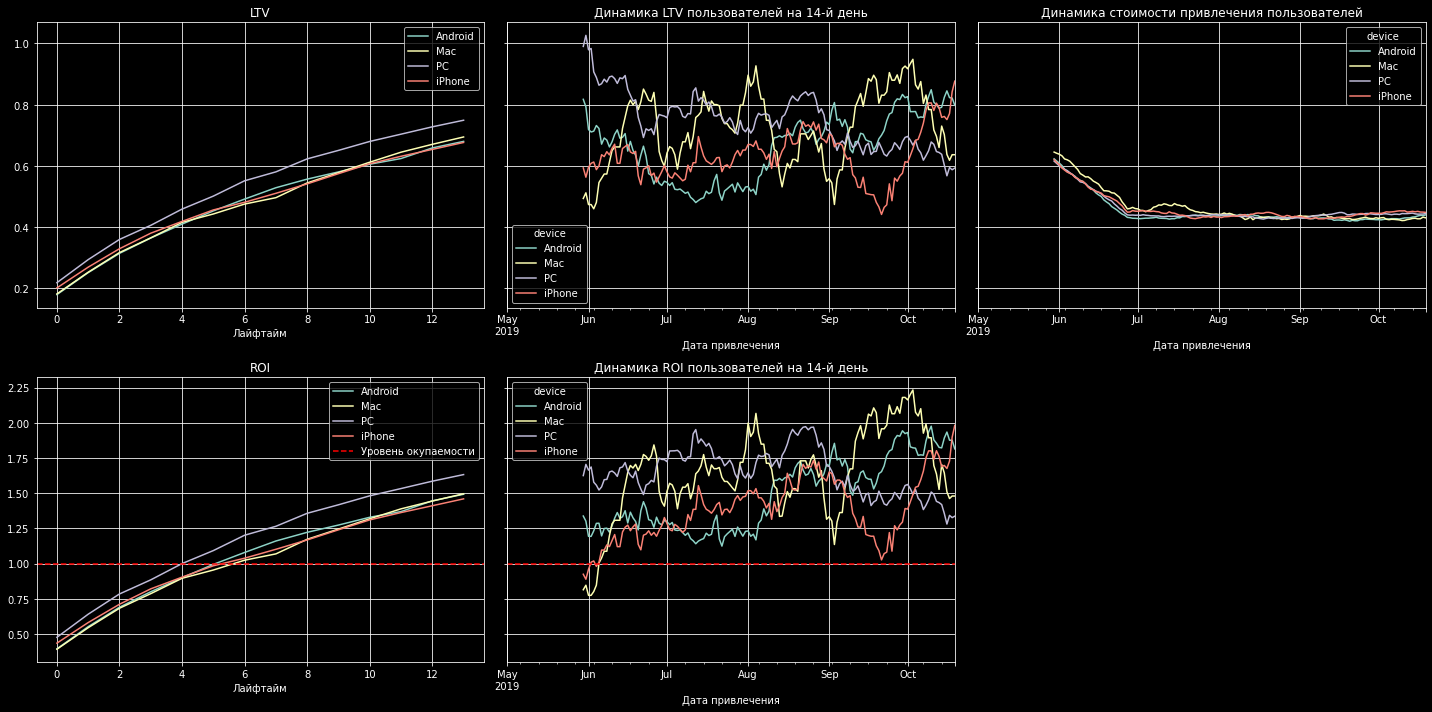

In [57]:
#смотрим окупаемость с разбивкой по устройствам
profiles_other = profiles.query('region != "United States"')
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_other, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
)

Все устройства уже на 5-й день окупаются, наблюдается снижение CAC, потом идет стабильно.

**Вывод**  
По правилам компании окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей. Реклама за этот лайфтайм, в целом, не окупается. Стоимость привлечения посетителей растет.  
По устройствам выявлено снижение динамики окупаемости к 14 дню у всех при росте стоимости привлечения посетителей. Mac, iPhone и Android показали результаты ниже уровня окупаемости, при этом у них же выявлены наибольшие расходы на привлечение. В Америке у посетителей по всем устройствам окупаемость в районе 70%.  
Из всех стран Америка оказалась единственной страной, которая продемонстрировала убытки по ROI при росте стоимости привлечения посетителей. Затраты на привлечение посетителей в Америке не оправдались.
Обнаружены большие расходы на канале TipTop, который в результате не окупился. Также не окупились каналы AdNonSense и FaceBoom.

## Общий вывод


Посетителей из Америки значительно больше (61829 посетителей, что составляет примерно 70% от общего количества). Проблемы неокупаемости обнаружились именно в этой стране. Большие расходы на американские рекламные каналы TipTop и FaceBoom не оправдались. Привлечение одного пользователя из канал TipTop обошлось компании в среднем в 2.76, из FaceBoom - 1.11. На TipTop расходы увеличивались с каждым месяцем.  
Маркетинговому отделу рекомендуется сократить финансирование на рекламные каналы TipTop и FaceBoom (для Америки) и AdNonSense (для Европы). Эти каналы не окупились. Посетители из FaceBoom и AdNonSense плохо удерживаются. В Америке пользователи всех устройств не принесли достаточно прибыли, хотя расходы на их привлечение постоянно росли. Необходимо проследить эффективность используемых рекламных каналов. Целесообразно ли тратить такие большие суммы на привлечение пользователей. Посоветовал бы посмотреть другие рекламные каналы для Америки, такие как YRabbit, MediaTornado, RocketSuperAds. Они окупились уже во второй день. За счет сокращения бюджета на рекламные каналы TipTop и FaceBoom можно попробовать начать рекламироваться в другие страны Европы, по окупаемости в Европе ситуация стабильная.